## Importando Bibliotecas ##

In [1]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('.'), '..')))

In [2]:
from data.generate_data import generate

## Adquirindo os Dados ##

### Através do Scrapping no site da Defesa Civíl de Rio do Sul e da API Open-Meteo foram adquiridos os dados relacionados as enchentes a partir de 2019-01-01 até 2024-12-31 ###

In [3]:
train_df = generate(
    start_date="2019-01-01",
    end_date="2024-12-31",
    type="train",
    save=False
)

2025-05-03 11:16:47.583 | INFO     | data.scraping:__init__:12 - WebScraper inicializado
2025-05-03 11:16:47.583 | INFO     | data.generate_data:__init__:32 - DataGenerator initialized with output directory: /Users/matheus/Documents/projects/Enchentes/data/output
2025-05-03 11:16:47.584 | INFO     | data.generate_data:generate:198 - Generating train dataset from 2019-01-01 to 2024-12-31
2025-05-03 11:16:47.584 | INFO     | data.generate_data:_get_weather_data:45 - Fetching weather data from 2019-01-01 to 2024-12-31
2025-05-03 11:16:53.177 | INFO     | data.generate_data:_get_weather_data:49 - Weather data fetched successfully: (52608, 42) rows
2025-05-03 11:16:53.178 | INFO     | data.generate_data:_get_water_level_data:66 - Scraping water level data from 2019-01-01 to 2024-12-31
2025-05-03 11:16:53.178 | INFO     | data.scraping:parse_data:24 - Iniciando análise de dados de 2019-01-01 até 2024-12-31
2025-05-03 11:16:53.180 | INFO     | data.scraping:parse_data:30 - Serão processados 7

Processando intervalos:   0%|          | 0/731 [00:00<?, ?it/s]

2025-05-03 11:20:38.587 | WARNING  | data.scraping:parse_data:42 - Intervalo de datas vazio encontrado, pulando
2025-05-03 11:20:38.587 | INFO     | data.scraping:parse_data:68 - Análise de dados concluída com sucesso
2025-05-03 11:20:38.664 | INFO     | data.scraping:parse_data:80 - Formato final do DataFrame: (35747, 2)
2025-05-03 11:20:38.665 | INFO     | data.generate_data:_get_water_level_data:69 - Water level data scraped successfully: (35747, 2) rows
2025-05-03 11:20:40.919 | INFO     | data.generate_data:_merge_datasets:107 - Datasets merged successfully: (52608, 44) rows


Generating feature engineering features:   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-03 11:20:43.884 | INFO     | data.generate_data:_process_data:173 - Data processing completed: (52538, 556) rows


In [4]:
train_df.head()

,time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,snowfall,showers,...,wind_gusts_10m_lag_16h,wind_gusts_10m_lag_17h,wind_gusts_10m_lag_18h,wind_gusts_10m_lag_19h,wind_gusts_10m_lag_20h,water_level_next_1h,water_level_next_3h,water_level_next_6h,water_level_next_12h,water_level_next_24h
46,2019-01-02 22:00:00,26.4,88,24.2,31.8,None,0.0,0.0,0.0,0.0,...,50.4,40.0,27.4,23.0,18.7,1.08,1.09,1.08,1.04,0.97
47,2019-01-02 23:00:00,25.6,91,24.0,30.6,None,0.0,0.0,0.0,0.0,...,40.0,27.4,23.0,18.7,18.0,1.08,1.08,1.08,1.04,1.02
48,2019-01-03 00:00:00,24.5,96,23.9,29.8,None,0.0,0.0,0.0,0.0,...,27.4,23.0,18.7,18.0,12.6,1.09,1.10,1.09,1.01,1.02
49,2019-01-03 01:00:00,24.3,97,23.8,29.7,None,0.0,0.0,0.0,0.0,...,23.0,18.7,18.0,12.6,9.7,1.08,1.08,1.08,1.02,1.01
50,2019-01-03 02:00:00,24.1,98,23.8,29.6,None,0.0,0.0,0.0,0.0,...,18.7,18.0,12.6,9.7,10.1,1.10,1.08,1.07,0.99,1.01


## EDA ##
### 1. Através da média do nível do rio de cada mês desde 2019 até 2024, foi possível se analisar através de gráficos de barra quais foram os mêses que mais houveram um nível alto do rio ###

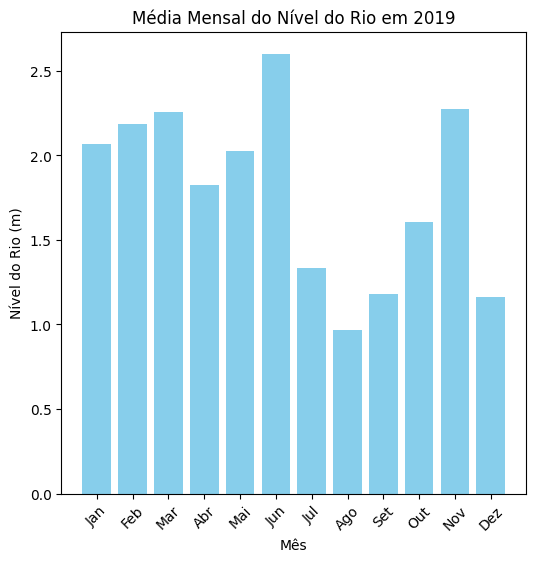

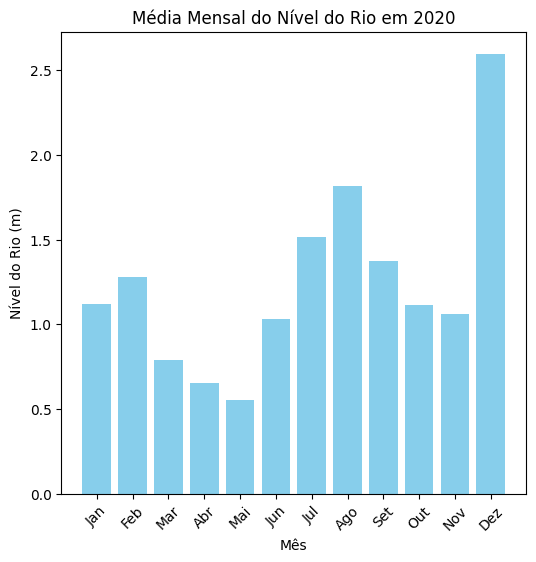

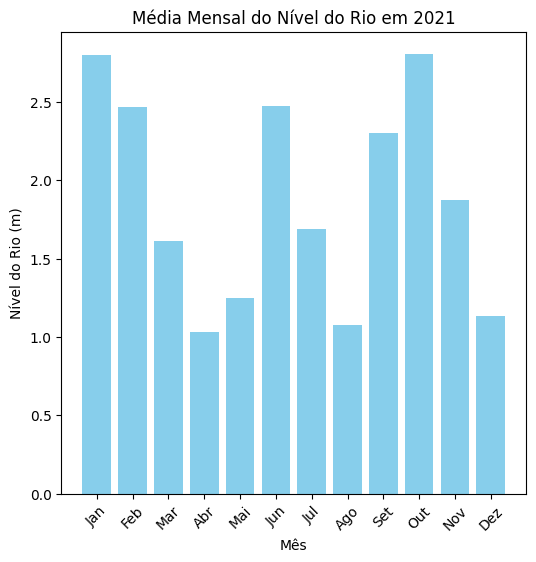

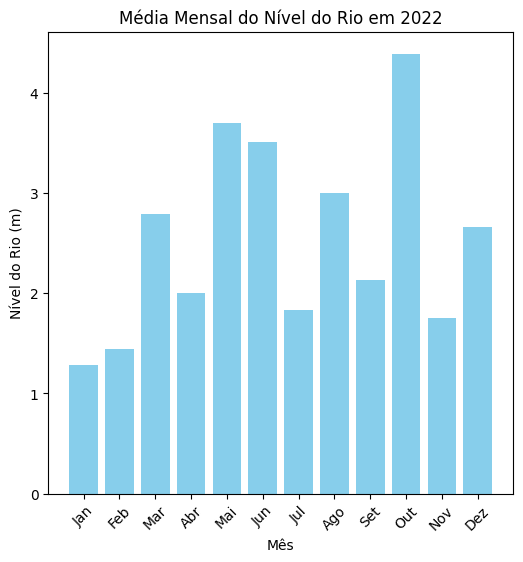

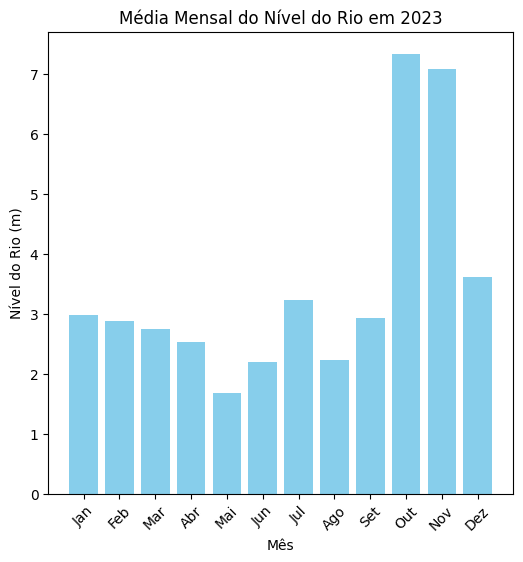

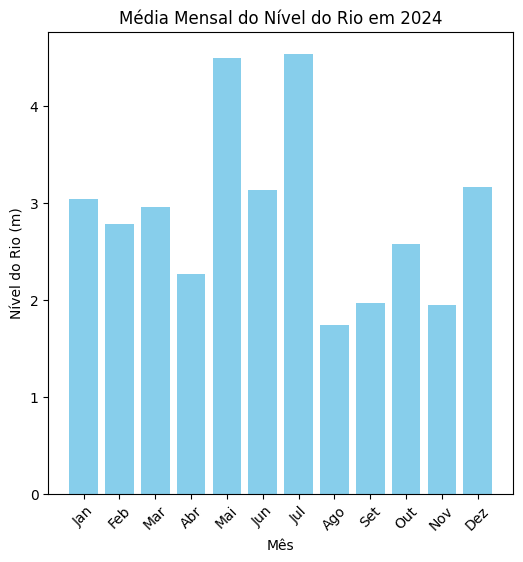

In [5]:
def month_set(ano):
    year_df = train_df[train_df['time'].dt.year == ano].copy()
    year_df['mes'] = year_df['time'].dt.month
    media_ano = year_df.groupby('mes')['water_level'].mean().reset_index()
    return media_ano

def plot_month(ano, media_ano):
    plt.bar(media_ano['mes'], media_ano['water_level'], color='skyblue')
    plt.xlabel('Mês')
    plt.ylabel('Nível do Rio (m)')
    plt.title(f'Média Mensal do Nível do Rio em {ano}')
    plt.xticks(media_ano['mes'], 
               ['Jan', 'Feb', 'Mar', 'Abr', 'Mai', 'Jun', 
                'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
    plt.xticks(rotation=45)
    plt.gcf().set_size_inches(6, 6)
    plt.show()

def loop_func(ano_inicial):
    if ano_inicial == 2019:
        while ano_inicial <= 2024:
            media = month_set(ano_inicial)
            plot_month(ano_inicial, media)
            ano_inicial += 1
    else:
        print("Erro: ano inicial deve ser 2019")
loop_func(2019)

### 2. Após descobrir os mêses que mais houveram um número maior na média do nível do rio, foi necessário analisar tais mêses para descobrir as features que influenciavam o aumento do nível do rio ###
exemplo:

In [6]:
month_df = train_df[train_df['time'].dt.year == 2023]
month_df['mes'] = month_df['time'].dt.month
month_df = month_df.loc[month_df['mes'] == 10]
month_df['dia'] = month_df['time'].dt.day
day_df = month_df.groupby('dia')['water_level'].mean().reset_index()
#mean_month = month_df.groupby('mes')['water_level'].mean().reset_index()
day_df

,dia,water_level
0,1,4.055833
1,2,4.231250
2,3,3.728333
3,4,5.586667
4,5,7.849167
5,6,6.996250
6,7,7.842083
7,8,9.907292
8,9,10.775000
9,10,10.532917


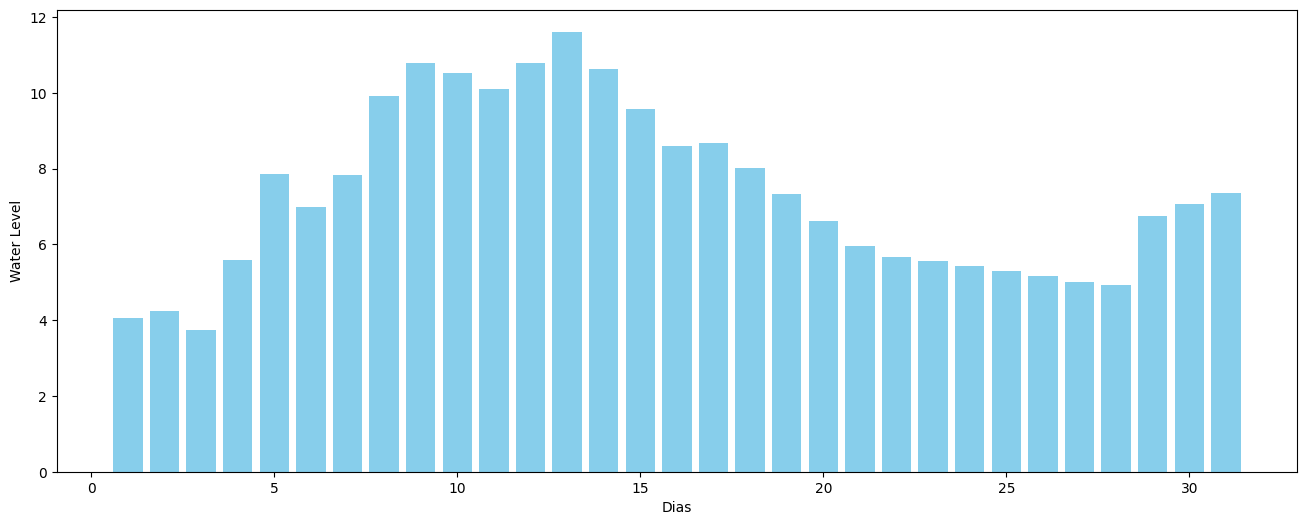

In [7]:
plt.bar(day_df['dia'], day_df['water_level'], color='skyblue')
plt.ylabel('Water Level')
plt.xlabel('Dias')
plt.gcf().set_size_inches(16, 6)
plt.show()

In [8]:
month_df.loc[month_df['time'].isin(['2023-10-01', '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08', '2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15', '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-21', '2023-10-22', '2023-10-23', '2023-10-24', '2023-10-25', '2023-10-26', '2023-10-27', '2023-10-28', '2023-10-29'])]

,time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,snowfall,showers,...,wind_gusts_10m_lag_18h,wind_gusts_10m_lag_19h,wind_gusts_10m_lag_20h,water_level_next_1h,water_level_next_3h,water_level_next_6h,water_level_next_12h,water_level_next_24h,mes,dia
41616,2023-10-01,18.0,100,18.0,19.8,None,0.4,0.4,0.0,0.0,...,32.8,27.7,26.6,4.00,4.040000,4.050000,3.980,4.26,10,1
41640,2023-10-02,16.1,85,13.6,15.6,None,0.0,0.0,0.0,0.0,...,42.1,29.5,27.4,4.26,4.254545,4.246364,4.230,4.20,10,2
41664,2023-10-03,14.2,75,9.8,13.1,None,0.0,0.0,0.0,0.0,...,25.6,26.6,31.3,4.19,4.150000,4.070000,3.770,2.95,10,3
41688,2023-10-04,17.1,89,15.4,18.3,None,0.0,0.0,0.0,0.0,...,9.7,7.2,4.3,2.91,2.830000,3.030000,6.100,8.29,10,4
41712,2023-10-05,17.2,100,17.2,19.0,None,0.0,0.0,0.0,0.0,...,34.6,34.6,37.1,8.29,8.206364,8.080909,7.830,7.37,10,5
41736,2023-10-06,15.8,90,14.1,16.4,None,0.0,0.0,0.0,0.0,...,19.1,22.7,23.4,7.34,7.270000,7.190000,6.920,6.63,10,6
41760,2023-10-07,18.7,97,18.2,21.3,None,1.0,1.0,0.0,0.0,...,16.9,14.8,12.2,6.62,6.580000,6.540000,7.790,9.50,10,7
41784,2023-10-08,18.1,98,17.7,20.3,None,0.1,0.1,0.0,0.0,...,21.6,11.2,6.8,9.50,9.577273,9.693182,9.925,10.35,10,8
41808,2023-10-09,15.8,100,15.7,17.1,None,0.0,0.0,0.0,0.0,...,26.3,23.4,20.9,10.43,10.580000,10.750000,10.890,10.82,10,9
41832,2023-10-10,16.9,89,15.1,17.1,None,0.0,0.0,0.0,0.0,...,22.3,34.6,36.0,10.80,10.760000,10.690000,10.510,10.29,10,10


### 3. Assim como nos outras situações de enchentes analisadas, foi encontrado os seguintes padrões: ###
#### a) temperature_2m = variando entre 13°C a 23.1°C (mais comum ser 19°C) ou 6.2°C a 15.9°C ####
#### b) relative_humidity_2m = variando entre 88% a 100% ou 75% a 100%, sendo +90% quase certeza a vinda de uma chuva ####
#### c) rain = variando entre 1.0mm a 4.1mm, geralmente havendo uma constância/"acûmulo" em 0.X ####
#### *d) rain_24h = variando entre 12.5mm a 64.6mm, representando que quanto maior for o seu valor, maior será magnificiência da enchente, ou seja, maior o valor no nível do rio ####

### 4. Correlação ###
#### Para que seja possível aprimorar ainda mais o resultado da previsão foi feito um estudo das correlações ####

In [9]:
features = month_df.loc[:, ['temperature_2m', 'relative_humidity_2m', 'apparent_temperature', 'water_level_next_3h', 'water_level_next_24h', 'water_level_next_6h']]
features_df = pd.DataFrame(data=features)
features_df.corr()

,temperature_2m,relative_humidity_2m,apparent_temperature,water_level_next_3h,water_level_next_24h,water_level_next_6h
temperature_2m,1.000000,-0.549074,0.970498,-0.232308,-0.165852,-0.226376
relative_humidity_2m,-0.549074,1.000000,-0.380238,0.151534,0.242242,0.174190
apparent_temperature,0.970498,-0.380238,1.000000,-0.221597,-0.129162,-0.209380
water_level_next_3h,-0.232308,0.151534,-0.221597,1.000000,0.877482,0.994864
water_level_next_24h,-0.165852,0.242242,-0.129162,0.877482,1.000000,0.897005
water_level_next_6h,-0.226376,0.174190,-0.209380,0.994864,0.897005,1.000000


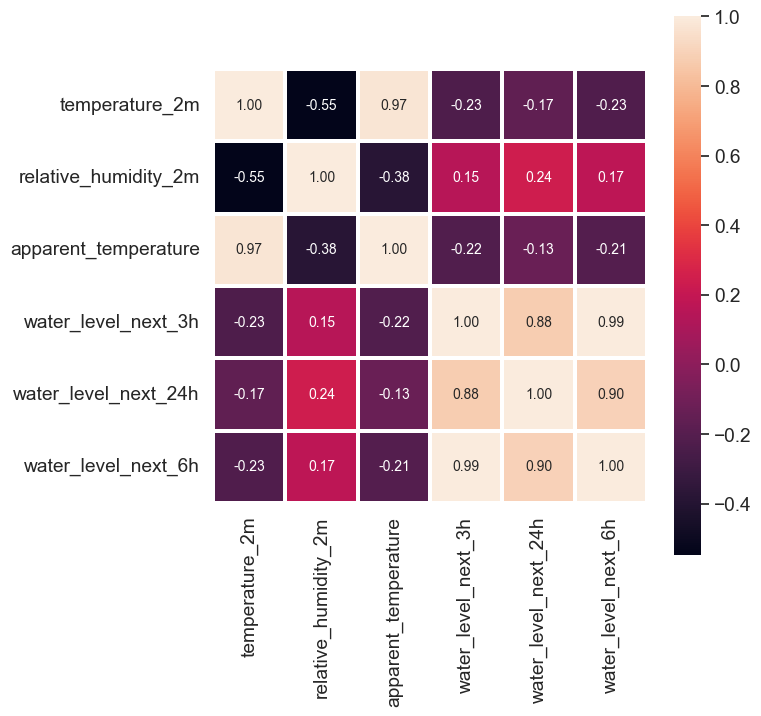

In [10]:
plt.figure(figsize=(7, 7))
sns.set(font_scale=1.25)
sns.heatmap(features_df.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=features_df.columns , xticklabels=features_df.columns
            )
plt.show()

### Modelos básicos de regressão do Scikit-learn e comparação de resultados ###
**Serão testados os seguintes modelos:**

LinearRegression

Ridge

Lasso

Elastic Net

Stochastic Gradient Descent

DecisionTreeRegressor

RandomForestRegressor

SVR

GXBoost

LinearRegression

In [11]:
# create a list of features except time and features starting with water_level
features = [column for column in train_df.columns if column not in ['time'] + [f"water_level_next_{h}h" for h in [1, 3, 6, 12, 24]]]
train_df[features].head()


,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,snowfall,showers,snow_depth,...,wind_gusts_10m_lag_11h,wind_gusts_10m_lag_12h,wind_gusts_10m_lag_13h,wind_gusts_10m_lag_14h,wind_gusts_10m_lag_15h,wind_gusts_10m_lag_16h,wind_gusts_10m_lag_17h,wind_gusts_10m_lag_18h,wind_gusts_10m_lag_19h,wind_gusts_10m_lag_20h
46,26.4,88,24.2,31.8,None,0.0,0.0,0.0,0.0,0.0,...,16.6,26.3,45.0,46.1,42.8,50.4,40.0,27.4,23.0,18.7
47,25.6,91,24.0,30.6,None,0.0,0.0,0.0,0.0,0.0,...,26.3,45.0,46.1,42.8,50.4,40.0,27.4,23.0,18.7,18.0
48,24.5,96,23.9,29.8,None,0.0,0.0,0.0,0.0,0.0,...,45.0,46.1,42.8,50.4,40.0,27.4,23.0,18.7,18.0,12.6
49,24.3,97,23.8,29.7,None,0.0,0.0,0.0,0.0,0.0,...,46.1,42.8,50.4,40.0,27.4,23.0,18.7,18.0,12.6,9.7
50,24.1,98,23.8,29.6,None,0.0,0.0,0.0,0.0,0.0,...,42.8,50.4,40.0,27.4,23.0,18.7,18.0,12.6,9.7,10.1


In [12]:
X = train_df[features]
y = train_df[['water_level_next_24h']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.linear_model import LinearRegression
mliearn = LinearRegression()
mliearn.fit(X_train.fillna(0), y_train)
y_pred = mliearn.predict(X_test.fillna(0))
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 0.17251413521420328
R² (coeficiente de determinação): 0.9290277554829125


Rigde

In [14]:
from sklearn.linear_model import Ridge
mridge = Ridge(alpha=1.0)
mridge.fit(X_train.fillna(0), y_train)
y_pred = mridge.predict(X_test.fillna(0))
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 0.17251850779671546
R² (coeficiente de determinação): 0.9290259566042592


Lasso

In [15]:
from sklearn.linear_model import Lasso
mlasso = Lasso(alpha=0.1)
mlasso.fit(X_train.fillna(0), y_train)
y_pred = mlasso.predict(X_test.fillna(0))
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 0.20251671927643825
R² (coeficiente de determinação): 0.9166847046971581


Elastic net

In [16]:
from sklearn.linear_model import ElasticNet
modelo_elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)
modelo_elastic.fit(X_train.fillna(0), y_train)
y_pred = modelo_elastic.predict(X_test.fillna(0))
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 0.19845869533078148
R² (coeficiente de determinação): 0.9183541740850998


Stochastic Gradient Descent


In [17]:
from sklearn.linear_model import SGDRegressor
modelo_sgd = SGDRegressor(
penalty='l2',        # 'l2' = Ridge, 'l1' = Lasso, 'elasticnet' = ambos
alpha=0.001,         # força da regularização
max_iter=1000,       # número máximo de iterações
tol=1e-3,            # tolerância pro critério de parada
random_state=42
)
modelo_sgd.fit(X_train.fillna(0), y_train)
y_pred = modelo_sgd.predict(X_test.fillna(0))
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 4.667555956215779e+34
R² (coeficiente de determinação): -1.9202306072509063e+34


DecisionTreeRegressor


In [18]:
from sklearn.tree import DecisionTreeRegressor
modelo_arvore = DecisionTreeRegressor(random_state=42, max_depth=5)
modelo_arvore.fit(X_train.fillna(0), y_train)
y_pred = modelo_arvore.predict(X_test.fillna(0))
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 0.23996499641572588
R² (coeficiente de determinação): 0.9012784988313424


RandomForestRegressor

In [19]:
import joblib
from sklearn.ensemble import RandomForestRegressor
modelo_floresta = RandomForestRegressor(random_state=42, n_estimators=100)
modelo_floresta.fit(X_train.fillna(0), y_train)
y_pred = modelo_floresta.predict(X_test.fillna(0))
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))
joblib.dump(modelo_floresta, 'modelo_random_forest.pkl')
print('Modelo salvo como modelo_random_forest.pkl')

Erro médio quadrático (MSE): 0.05233894168490869
R² (coeficiente de determinação): 0.9784677808434964
Modelo salvo como modelo_random_forest.pkl


SVR

In [20]:
from sklearn.svm import SVR
modelo_svr = SVR(kernel='rbf')
modelo_svr.fit(X_train.fillna(0), y_train)
y_pred = modelo_svr.predict(X_test.fillna(0))
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 2.2142420802816924
R² (coeficiente de determinação): 0.08906171574491084


XGBOOST

In [21]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import json

# Modelo base
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Definição do grid de hiperparâmetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Busca aleatória
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Treinamento com os melhores parâmetros
random_search.fit(X_train.fillna(0), y_train)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test.fillna(0))

# Salvando modelo
best_model.save_model("modelo_salvo1.json")

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Melhores parâmetros encontrados:", random_search.best_params_)
print(f"RMSE no conjunto de teste: {rmse:.2f}")
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   6.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   6.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   6.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.6; total time=   7.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.6; total time=   7.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.6; total time=   5.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=  11.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=  11.4s
[CV] END c

### Resultado: XGBoost ###

### Previsão e Resultado ###
#### Escolhendo uma data, houve um teste de resultado para saber a proximidade da previsão com o resultado verdadeiro a partir do XGBoost ####

In [26]:
predict_df = generate(
    start_date="2025-01-01",
    end_date="2025-04-30",
    type="train",
    save=False
)

2025-05-03 11:50:19.863 | INFO     | data.scraping:__init__:12 - WebScraper inicializado
2025-05-03 11:50:19.866 | INFO     | data.generate_data:__init__:32 - DataGenerator initialized with output directory: /Users/matheus/Documents/projects/Enchentes/data/output
2025-05-03 11:50:19.868 | INFO     | data.generate_data:generate:198 - Generating train dataset from 2025-01-01 to 2025-04-30
2025-05-03 11:50:19.870 | INFO     | data.generate_data:_get_weather_data:45 - Fetching weather data from 2025-01-01 to 2025-04-30
2025-05-03 11:50:21.699 | INFO     | data.generate_data:_get_weather_data:49 - Weather data fetched successfully: (2880, 42) rows
2025-05-03 11:50:21.700 | INFO     | data.generate_data:_get_water_level_data:66 - Scraping water level data from 2025-01-01 to 2025-04-30
2025-05-03 11:50:21.700 | INFO     | data.scraping:parse_data:24 - Iniciando análise de dados de 2025-01-01 até 2025-04-30
2025-05-03 11:50:21.705 | INFO     | data.scraping:parse_data:30 - Serão processados 40

Processando intervalos:   0%|          | 0/40 [00:00<?, ?it/s]

2025-05-03 11:50:34.772 | INFO     | data.scraping:parse_data:68 - Análise de dados concluída com sucesso
2025-05-03 11:50:34.782 | INFO     | data.scraping:parse_data:80 - Formato final do DataFrame: (1960, 2)
2025-05-03 11:50:34.782 | INFO     | data.generate_data:_get_water_level_data:69 - Water level data scraped successfully: (1960, 2) rows
2025-05-03 11:50:34.924 | INFO     | data.generate_data:_merge_datasets:107 - Datasets merged successfully: (2880, 44) rows


Generating feature engineering features:   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-03 11:50:35.153 | INFO     | data.generate_data:_process_data:173 - Data processing completed: (2856, 556) rows


In [27]:
import xgboost as xgb

# Carregar o modelo treinado
modelo_xgb = xgb.XGBRegressor()
modelo_xgb.load_model('modelo_salvo1.json')

# Adiciona ao DataFrame
predict_df['predicted_water_level_next_24h'] = modelo_xgb.predict(predict_df[features].fillna(0))

# Adiciona intervalo de confiança em 30% de erro
predict_df['predicted_water_level_next_24h_std'] = predict_df['predicted_water_level_next_24h'].std()
predict_df['predicted_water_level_next_24h_lower'] = predict_df['predicted_water_level_next_24h'] - 0.3 * predict_df['predicted_water_level_next_24h_std']
predict_df['predicted_water_level_next_24h_upper'] = predict_df['predicted_water_level_next_24h'] + 0.3 * predict_df['predicted_water_level_next_24h_std']

# Exibe
predict_df[['time','predicted_water_level_next_24h_lower','predicted_water_level_next_24h', 'predicted_water_level_next_24h_upper']]

,time,predicted_water_level_next_24h_lower,predicted_water_level_next_24h,predicted_water_level_next_24h_upper
0,2025-01-01 00:00:00,1.678080,1.914402,2.150724
1,2025-01-01 01:00:00,1.642160,1.878482,2.114805
2,2025-01-01 02:00:00,1.593924,1.830246,2.066568
3,2025-01-01 03:00:00,1.591254,1.827576,2.063898
4,2025-01-01 04:00:00,1.514974,1.751296,1.987618
...,...,...,...,...
2851,2025-04-29 19:00:00,0.844831,1.081153,1.317475
2852,2025-04-29 20:00:00,0.865439,1.101761,1.338083
2853,2025-04-29 21:00:00,0.890127,1.126449,1.362771
2854,2025-04-29 22:00:00,0.867078,1.103400,1.339721


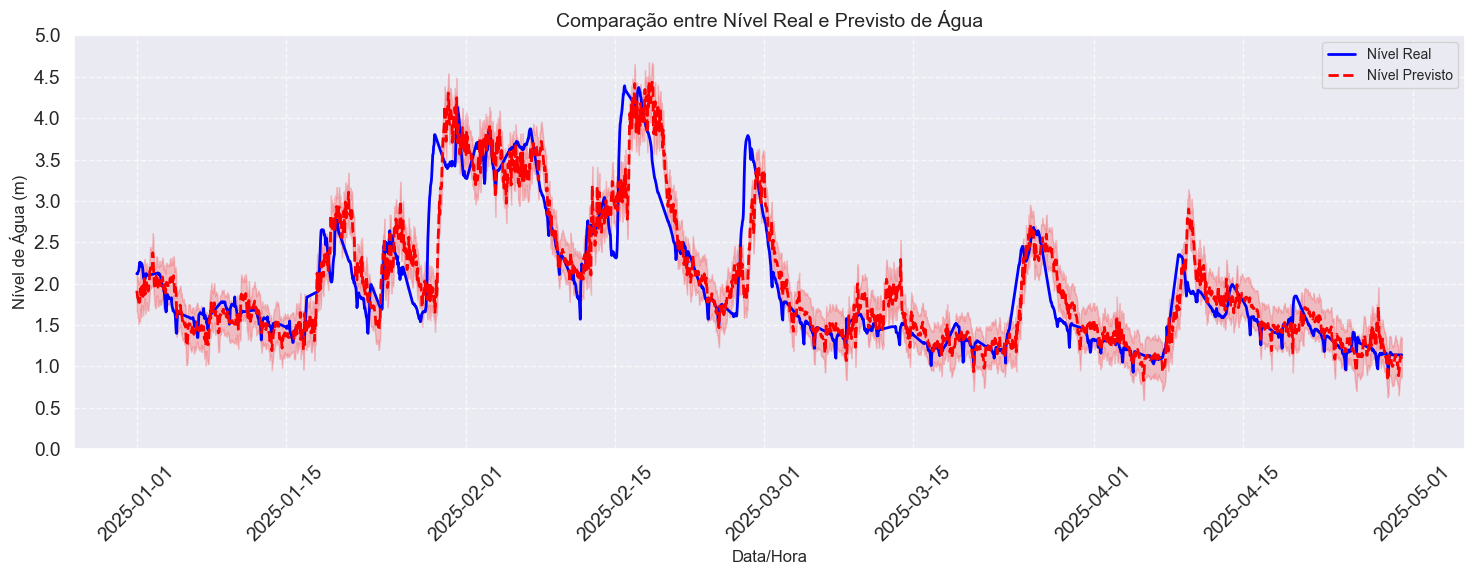

In [29]:
plt.figure(figsize=(15, 6))

# Plotando o nível real
plt.plot(predict_df['time'], predict_df['water_level_next_24h'], 
         label='Nível Real', linewidth=2, color='blue')

# Plotando o nível previsto
plt.plot(predict_df['time'], predict_df['predicted_water_level_next_24h'], 
         label='Nível Previsto', linewidth=2, color='red', linestyle='--')

# Plotando o intervalo de confiança
plt.fill_between(predict_df['time'], 
                 predict_df['predicted_water_level_next_24h_lower'], 
                 predict_df['predicted_water_level_next_24h_upper'], 
                 color='red', alpha=0.2)

# Configurações do gráfico
plt.title('Comparação entre Nível Real e Previsto de Água', fontsize=14)
plt.xlabel('Data/Hora', fontsize=12)
plt.ylabel('Nível de Água (m)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

plt.xticks(rotation=45)

# Configurando incrementos do eixo y de 0.5 em 0.5
ymin, ymax = plt.ylim()
plt.yticks(np.arange(np.floor(ymin), np.ceil(ymax) + 0.5, 0.5))

plt.tight_layout()

plt.show()